# Summary

Milestone 3 of reinforcement learning project. Notebook to get a GMRES that (1) works on GPU and (2) works with batched data.

## TODO

1. Finish testing.
2. Setup dataset from other notebook.
3. Integrate the GPU GMRES with the loss to see how much a single step will cost.
4. Improve loss from Milestone 2.
    1. Vectorize it.
    2. Additional terms for sparsity?
5. Begin to pretrain actor.
    1. First experiment with models.
        1. Minimize eye_dist.
        2. Try different layers.
        3. Try edge prediction. 
        4. REALLY TRY TO GET SPARSITY. (Log-sum penalty) ?
    2. Anything that works, store in a python file.
    3. Build out a python file that has models that have worked.
    4. Make sure to save weights and successfully plots to /Weights and /Plots
6. Train just on small (results).
7. Train just on large (results).
8. Train SMALLER -> freeze middle -> finetune on large.
9. If SMALLER -> LARGER leads to shorter training times and >= results, include as a novelty presented in paper (like many PDE discretization techniques, it is common to control the size, we found results that suggest that the model can generalize well to smaller discretization spaces and be applied effectively to larger state spaces).

# Dataset

Same helmholtz dataset from milestone 2.

In [1]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import torch

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

In [45]:
def generate_random_helmholtz(n, density=0.1):
    L = 1.0
    k = np.random.uniform(1, 2)  # Random wavenumber
    h = L / (n - 1)  

    # Discretization of Helmholtz operator (1D)
    diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]

    helmholtz = sp.diags(diagonals, [-1, 0, 1]) / h**2 + k**2 * sp.eye(n)

    # Ensure no perturbations on the tridiagnonal
    perturb = sp.random(n, n, density=density) * np.max(helmholtz)
    
    perturb.setdiag(0)  # Main diagonal
    perturb.setdiag(0, k=1)  # First upper diagonal
    perturb.setdiag(0, k=-1)  # First lower diagonal
        
    return helmholtz+perturb

In [46]:
def test_singularity(mat):
    det_mat = np.linalg.det(mat)
    print(det_mat)

    if np.isclose(det_mat, 0):
        print("Matrix is singular.")
        return False
        
    rank_mat = np.linalg.matrix_rank(mat)
    if rank_mat < mat.shape[0]:
        print("Matrix is singular.")
        return False
    
    print("Matrix is non-singular.")
        
    return True

In [50]:
test_singularity(normalize_features(torch.from_numpy(generate_random_helmholtz(20).toarray())))

-9.440187e-07
Matrix is non-singular.


True

In [ ]:
u, s, v = torch.svd(normalize_features(torch.from_numpy(generate_random_helmholtz(20).toarray())))

# Condition number: ratio of largest to smallest singular value
condition_number = s.max() / s.min()
print(condition_number)

tensor(934.8749)


In [51]:
import matplotlib.pyplot as plt

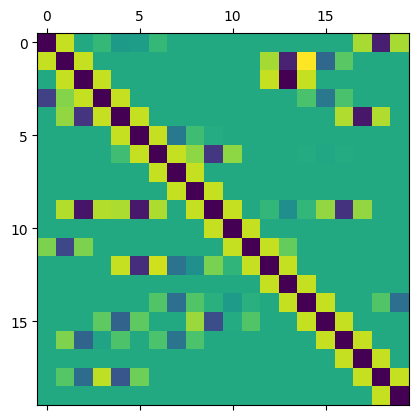

In [52]:
plt.matshow(normalize_features(torch.from_numpy(generate_random_helmholtz(20).toarray())))

In [7]:
def normalize_features(graph_data):
    x_min = graph_data.min()
    x_max = graph_data.max()
    out = (graph_data - x_min) / (x_max - x_min + 1e-8)
    return out.float()

def normalize_edge_attr(graph_data):
    e_min = graph_data.min()
    e_max = graph_data.max()
    out = (graph_data - e_min) / (e_max - e_min + 1e-8)
    return out.float()

In [145]:
class HelmHoltzDataset(Dataset):
    def __init__(self, generator, checker, norm_feat, norm_edge, epoch_len, size=500, density=0.001, transform=None):
        super().__init__(None, transform)
        
        self.epoch_len = epoch_len
        self.mat_size = size
        self.mat_density = density
        
        self.generator = generator
        self.checker = checker
        
        self.norm_features = norm_feat
        self.norm_edge_attr = norm_edge

    def len(self):
        return self.epoch_len

    def get(self, idx):
        mat = self.generator(self.mat_size, self.mat_density)
        
        source_nodes, target_nodes = mat.nonzero()
        
        mat = torch.from_numpy(mat.toarray())
        source_nodes = torch.from_numpy(source_nodes)
        target_nodes = torch.from_numpy(target_nodes)
        
        edge_weights = mat[source_nodes, target_nodes]
        edge_index = torch.stack([source_nodes, target_nodes], dim=0).to(torch.int64)
        
        node_features = mat.float()
        edge_weights = self.norm_edge_attr(edge_weights)

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights)
        return data

In [146]:
dataset = HelmHoltzDataset(generate_random_helmholtz, test_singularity, normalize_features, normalize_edge_attr, 64*1000)
vdataset = HelmHoltzDataset(generate_random_helmholtz, test_singularity, normalize_features, normalize_edge_attr, 64*100)

In [147]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
vdataloader = DataLoader(vdataset, batch_size=1, shuffle=True)

In [148]:
next(iter(dataloader))

DataBatch(x=[500, 500], edge_index=[2, 2241], edge_attr=[2241], batch=[500], ptr=[2])

# GPU-GMRES

Computes GMRES solvers. Possibly get it to work with batches but I gave up.

Authored by https://github.com/devzhk/Pytorch-linalg 

In [18]:
from PytorchLinalg.linalg import GMRES
import torch
import scipy.sparse.linalg as spla

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
def solve(A, b):   
    A, b = A.to(device), b.to(device)
    return GMRES(A, b, track=True)

In [16]:
def manual_test(A, b, x):
    return torch.linalg.norm(A @ x - b)

In [30]:
def solve_scipy(A, b):
    A, b = A.cpu().numpy(), b.cpu().numpy()
    x, exit = spla.gmres(A, b, maxiter=20)
    print(exit)
    return x

## Testing

Make sure this actually works.

### Random (Garbage)

Should fail. No gurantee the matrix is any good.

In [31]:
def random_usage(n=20):    
    A = torch.randn(n, n, device=device)
    
    b = torch.randn(n, device=device)
    
    # Solve the systems
    sol, (conv_iter, errs) = solve(A, b)
    print (conv_iter)
    print(errs[-1] if len(errs) > 0 else []) # rel_tol
    
    return A, b, sol, conv_iter, errs

In [32]:
A, b, sol, conv_iter, errs = random_usage()

19
2.8677703767243656e-07


In [33]:
f'GMRES: {manual_test(A, b, sol)}, ZEROS: {manual_test(A, b, torch.zeros(20, device=device))}'

'GMRES: 2.1422588361019734e-06, ZEROS: 3.5401222705841064'

In [34]:
x = solve_scipy(A, b)

0


In [35]:
f'GMRES: {manual_test(A, b, torch.from_numpy(x).to(device))}, ZEROS: {manual_test(A, b, torch.zeros(20, device=device))}'

'GMRES: 1.998992274820921e-06, ZEROS: 3.5401222705841064'

### Random (Identity)

Converge in a single iteration.

In [19]:
def eye_usage(n=500):    
    A = torch.eye(n, device=device)
    
    b = torch.randn(n, device=device)
    
    # Solve the systems
    sol, (conv_iter, errs) = solve(A, b)
    print (conv_iter)
    print(errs[-1] if len(errs) > 0 else [])
    
    return A, b, sol, conv_iter, errs

In [20]:
A, b, sol, conv_iter, errs = eye_usage()

0
0.0


In [21]:
x = solve_scipy(A, b)

0


### Hilbert

Hilbert matrices from Milestone 1. Need a try catch for errors that arise from givens rotation.

In [22]:
from scipy.linalg import hilbert

In [23]:
def hilbert_usage(n=500):    
    A = torch.tensor(hilbert(n)).to(device, torch.float)
    
    b = torch.randn(n, device=device)
    
    # Solve the systems
    try:
        sol, (conv_iter, errs) = solve(A, b)
    except ValueError as e:
        print(f'ValueError: {e}, Givens-Rotation-Issue')
        return A, b, torch.zeros(n, device=device), -1, []
    
    print (conv_iter)
    print(errs[-1] if len(errs) > 0 else [])
    
    return A, b, sol, conv_iter, errs

In [24]:
A, b, sol, conv_iter, errs = hilbert_usage()

ValueError: 15-th cosine contains NaN, Givens-Rotation-Issue


In [25]:
f'GMRES: {manual_test(A, b, sol)}, ZEROS: {manual_test(A, b, torch.zeros(500, device=device))}'

'GMRES: 22.40157127380371, ZEROS: 22.40157127380371'

In [26]:
x = solve_scipy(A, b)

1000


In [27]:
f'GMRES: {manual_test(A, b, torch.from_numpy(x).to(device))}, ZEROS: {manual_test(A, b, torch.zeros(500, device=device))}'

'GMRES: 705.8778076171875, ZEROS: 22.40157127380371'

### Helmholtz 

Helmholtz matrices from Milestone 1.

In [28]:
import numpy as np
import scipy.sparse as sp

In [29]:
def generate_random_helmholtz(n, density=0.001):
    L = 1.0
    k = np.random.uniform(10, 200)  # Random wavenumber
    h = L / (n - 1)  

    # Discretization of Helmholtz operator (1D)
    diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]

    helmholtz = sp.diags(diagonals, [-1, 0, 1]) / h**2 + k**2 * sp.eye(n)

    # Ensure no perturbations on the tridiagnonal
    perturb = sp.random(n, n, density=density) * np.max(helmholtz)
    
    perturb.setdiag(0)  # Main diagonal
    perturb.setdiag(0, k=1)  # First upper diagonal
    perturb.setdiag(0, k=-1)  # First lower diagonal
        
    return helmholtz + perturb

In [30]:
def helmholtz_usage(n=500):    
    A = torch.from_numpy(generate_random_helmholtz(n).toarray()).to(device, torch.float)
    
    b = torch.randn(n, device=device)
    
    # Solve the systems
    try:
        sol, (conv_iter, errs) = solve(A, b)
    except ValueError as e:
        print(f'ValueError: {e}, Givens-Rotation-Issue')
        return A, b, torch.zeros(n, device=device), -1, []
    
    print (conv_iter)
    print(errs[-1] if len(errs) > 0 else [])
    
    return A, b, sol, conv_iter, errs

In [31]:
A, b, sol, conv_iter, errs = helmholtz_usage()

499
4.7439782065339386e-05


In [32]:
f'GMRES: {manual_test(A, b, sol)}, ZEROS: {manual_test(A, b, torch.zeros(500, device=device))}'

'GMRES: 0.00218977895565331, ZEROS: 23.201364517211914'

In [33]:
x = solve_scipy(A, b)

1000


In [34]:
f'GMRES: {manual_test(A, b, torch.from_numpy(x).to(device))}, ZEROS: {manual_test(A, b, torch.zeros(500, device=device))}'

'GMRES: 1.1512666940689087, ZEROS: 23.201364517211914'

## Loss Integration

Identity distance from Milestone 2 (with vectorized form). This will be the form going forward.

Update:
    Collapses onto zero matrix. Maximize distance from the zero matrix. This may also cause issues. They should be weighted.

\begin{equation}
    \mathcal{L} = \alpha_1\|XA - I\|_{fro} + \alpha_2\|A\|_1 - \alpha_3\|A\|_{fro}
\end{equation}
where $X$ is the input, $A$ is the output, and $\alpha = \left[1.0, 1.0, 0.01\right]$.

### TODO

In [41]:
from torch import nn

In [42]:
class IdenittyDistance(nn.Module):
    def __init__(self, l1=None, logsum=None):
        super().__init__()
        self.l1 = l1
        self.logsum = logsum
        
    def forward(self, inp, outp):
        avg_loss = 0
        
        batch_size = inp.ptr.shape[0] - 1
        identity = torch.eye(500, device=inp.x.device).expand(batch_size, -1, -1)
        inner_product = torch.bmm(outp.view(batch_size, 500, 500), inp.x.view(batch_size, 500, 500))
        det = torch.mean(torch.abs(torch.linalg.det(inner_product))).item()
        
        # TODO : Pre-pre, idk man
        
        # Maximize the determinent | Minimize the condition number     
        if False and det < 1.0:
            slog_det = torch.log(torch.abs(torch.linalg.det(inner_product)))
            avg_loss += -torch.mean(slog_det) * 1.0
            
        else:
            #eye_frobenius_loss = torch.norm(inner_product - identity, p='fro', dim=(1, 2))
            #avg_loss += torch.mean(eye_frobenius_loss) * 1.0
        
            singular_values = torch.linalg.svdvals(inner_product)
            log_singular_values = torch.log(singular_values)
            log_cond = log_singular_values.max(dim=1).values - log_singular_values.min(dim=1).values
            avg_loss += torch.mean(log_cond) * 1.0
        
            if self.l1 is not None:
                avg_loss += self.l1 * torch.norm(outp, p=1) * 1.0
            elif self.logsum is not None:
                avg_loss += torch.sum(torch.log(1 + torch.abs(outp) / self.logsum))
        
        return avg_loss

# Models

Potential models for actor network.

**NOTE:** Aim for a model roughly 10 GBs in size. Need room for critic, actor, and GMRES. 

In [43]:
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn.utils as nn_utils

In [69]:
def shared_training_loop(epoches, criterion, train_loader, valid_loader, model, lr, b=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=1e-3)

    train_log, valid_log = np.zeros(epoches), np.zeros(epoches)
    
    for epoch in range(epoches):
        
        train_loss = 0
        model.train()
        t_loader = tqdm(train_loader, desc=f'Train', leave=False, mininterval=2.0)
        for batch in t_loader:
            batch = batch.to(device)
            output = model(batch.x, batch.edge_index) if b is None else model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(batch, output.to_dense())

            t_loader.set_postfix(train_loss=loss.item())
            train_loss += loss.item()

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            
        valid_loss = 0
        model.eval()
        v_loader = tqdm(valid_loader, desc=f'Valid', leave=False, mininterval=2.0)
        for batch in v_loader:
            with torch.no_grad():
                batch = batch.to(device)
                output = model(batch.x, batch.edge_index) if b is None else model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(batch, output.to_dense())

                v_loader.set_postfix(valid_loss=loss.item())
                valid_loss += loss.item()
                
        print(f'Epoch: {epoch}, Train: {train_loss/len(t_loader)}, Valid: {valid_loss/len(v_loader)}')
        train_log[epoch], valid_log[epoch] = train_loss, valid_loss
        
        scheduler.step(valid_loss)
        
    return train_log, valid_log

In [45]:
import matplotlib.pyplot as plt

In [46]:
def plot_training(train_log, valid_log, title='EX', filename='ex'):
    plt.plot(train_log, label="Train")
    plt.plot(valid_log, label="Valid")
    plt.title(f'{title}: Train/Valid Log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.savefig(f'{filename}.png')
    plt.show()

## (Node Feature) Models

Models in which the direct node feature output is used as the estimate.

In [1]:
from neuralIncompleteFactorization.neuralif import models

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

In [7]:
kwargs = {
    "latent_size": 16, 
    "message_passing_steps": 4, 
    "skip_connections": 1,                  
    "augment_nodes": 1, 
    "global_features": 0, 
    "decode_nodes": 4,                  
    "normalize_diag": True, 
    "activation": True, 
    "aggregate": None, 
    "graph_norm": None,
    "two_hop": None, 
    "edge_features": 4, 
    "normalize": None
}

model = models.PreCondNet(**kwargs)

In [9]:
from neuralIncompleteFactorization.apps import data

In [15]:
data = data.matrix_to_graph(generate_random_helmholtz(500), np.random.rand(500))

In [16]:
data

Data(x=[500, 1], edge_index=[2, 2236], edge_attr=[2236, 1])

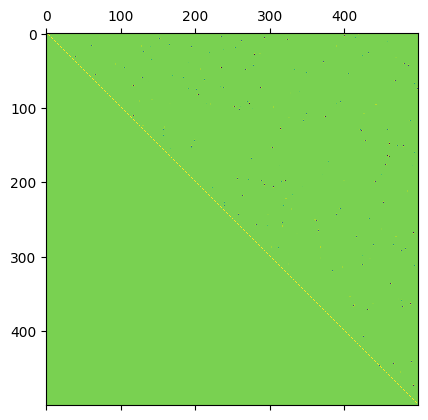

In [24]:
plt.matshow(model(data)[0].detach().to_dense())

In [8]:
model

PreCondNet(
  (mps): ModuleList(
    (0): GraphNet(
      (aggregate): MeanAggregation()
      (global_aggregate): MeanAggregation()
      (edge_block): MLP(
        (m): Sequential(
          (0): Linear(in_features=17, out_features=16, bias=True)
          (1): ReLU()
          (2): Linear(in_features=16, out_features=1, bias=True)
        )
      )
      (node_block): MLP(
        (m): Sequential(
          (0): Linear(in_features=9, out_features=16, bias=True)
          (1): ReLU()
          (2): Linear(in_features=16, out_features=8, bias=True)
        )
      )
    )
    (1-3): 3 x GraphNet(
      (aggregate): MeanAggregation()
      (global_aggregate): MeanAggregation()
      (edge_block): MLP(
        (m): Sequential(
          (0): Linear(in_features=18, out_features=16, bias=True)
          (1): ReLU()
          (2): Linear(in_features=16, out_features=1, bias=True)
        )
      )
      (node_block): MLP(
        (m): Sequential(
          (0): Linear(in_features=9, out_fe

### TransformerConv

Uses a transformer network to pass messages.

In [49]:
from torch_geometric.nn import TransformerConv

In [42]:
class GraphTransformer(nn.Module):
    def __init__(self, in_channels=500, hidden_channels=128, out_channels=500, heads=5, dropout=0.25, num_layers=5):
        super(GraphTransformer, self).__init__()
        
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        
        self.layers.append(TransformerConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        for _ in range(num_layers-2):
            self.layers.append(TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
        self.layers.append(TransformerConv(hidden_channels * heads, out_channels, heads=heads, dropout=dropout, concat=False))

    def forward(self, x, edge_index):
        for conv in self.layers[:-1]:
            x = conv(x, edge_index)
            x = self.activation(x)
        
        x = self.layers[-1](x, edge_index)
        
        return x

In [43]:
#gtransformer = GraphTransformer()
#gtransformer.load_state_dict(torch.load('temp.pth'))

/tmp/ipykernel_1245591/1449974174.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gtransformer.load_state_dict(torch.load('temp.pth'))


<All keys matched successfully>

In [44]:
epoches = 10
loader = dataloader
vloader = vdataloader
#model = gtransformer.to(device)
lr = 1e-5

In [45]:
#criterion = IdenittyDistance()

In [46]:
#train_log, valid_log = shared_training_loop(epoches, criterion, loader, vloader, model, lr)

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train: 21.471683229446413, Valid: 23.720226669311522


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, Train: 21.391578102111815, Valid: 23.527362289428712


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



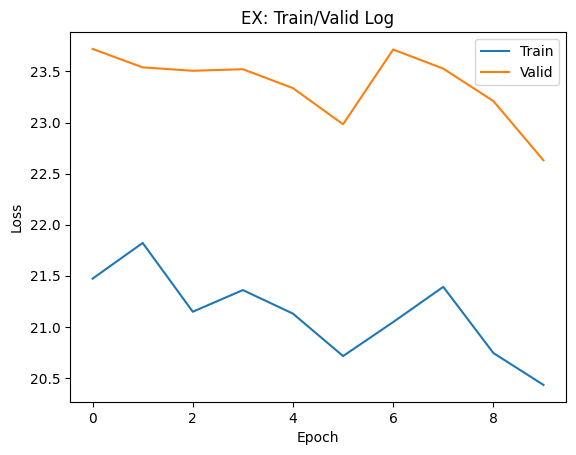

In [48]:
#plot_training(train_log /len(loader), valid_log/len(vloader))

In [49]:
def testing(model, dataset):
    d = dataset.get(0)
    out = model(d.x.to(device), d.edge_index.to(device))
    
    print(torch.norm(out.detach().cpu() @ d.x - torch.eye(500), p=2))
    print(torch.norm(out.detach().cpu() @ d.x, p=2))
    print(torch.norm(out.detach().cpu(), p=2))
    print(torch.norm(torch.eye(500), p=2))
    print(torch.linalg.det(out.detach().cpu()))
    
    print(torch.abs(torch.linalg.det(out.detach().cpu() @ d.x)))
    print(torch.abs(torch.linalg.det(out.detach().cpu() @ d.x)))
    plt.matshow(out.detach().cpu())
    plt.matshow(d.x)
    plt.matshow(d.x @  out.detach().cpu())

tensor(32.0027)
tensor(23.9043)
tensor(4.1071)
tensor(22.3607)
tensor(-0.)
tensor(0.)
tensor(0.)


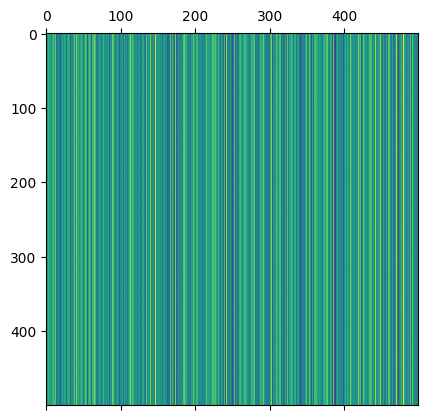

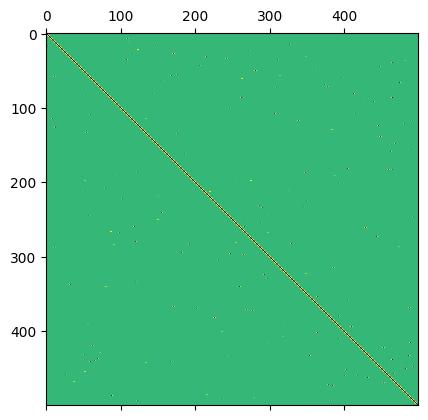

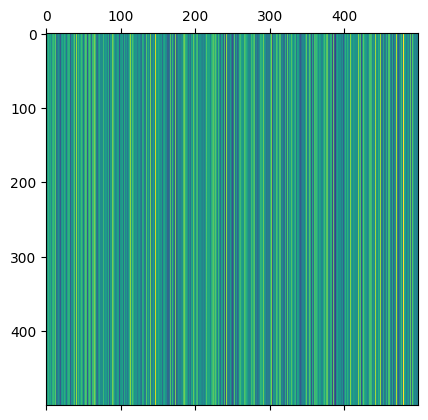

In [50]:
#testing(gtransformer, dataset)

### GCN

The basic GNN convolutional model.

### ChebConv

A hihger order convolutional model. **May be worth it to connect K with spectral properties of my input?**

## (Edge Prediction) Models

Models in which the node features are passed in pairs to linear layers and compute an edge weight.

Sharing a training loop means some things like edge prediction will happen within the model class.

This model fixes the sparsity to be exactly the same as the input by only computing entries on the edge indexes.

### TransformerConv

Uses a transformer network to pass messages.

This model is very broken. Some sort of index out of bounds, need to figure out where the issue is.

In [105]:
class GraphTransformer(nn.Module):
    def __init__(self, in_channels=500, hidden_channels=128, heads=5, dropout=0.25, num_layers=5):
        super(GraphTransformer, self).__init__()
        
        self.activation = nn.ReLU()
        self.layers = nn.ModuleList()
        
        self.layers.append(TransformerConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        for _ in range(num_layers - 2):
            self.layers.append(TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
        self.layers.append(TransformerConv(hidden_channels * heads, in_channels, heads=heads, dropout=dropout, concat=False))
        
        self.edge_scorer = nn.Linear(2 * in_channels, 1)  

    def forward(self, x_in, edge_index, batch):
        x = x_in
        for conv in self.layers:
            x = conv(x, edge_index)
            x = self.activation(x)
            
        # Compute edge scores
        row, col = edge_index  # source and target node indices for each edge
        edge_features = torch.cat([x[row], x[col]], dim=-1)  # Concatenate source and target embeddings
        edge_scores = self.edge_scorer(edge_features).squeeze(-1)  # Shape: (num_edges,)
        
        # Initialize batched sparse matrices
        num_nodes = 500
        batch_size = batch.max().item() + 1
        
        # Select edges belonging to the i-th graph in the batch
        batch_mask = (batch[row] == 0)
        batch_edges = edge_index[:, batch_mask]
        batch_scores = edge_scores[batch_mask]

        # Create a sparse matrix for the i-th graph
        sparse_matrix = torch.sparse_coo_tensor(
            batch_edges,
            batch_scores,
            (num_nodes, num_nodes)
        )
        
        return sparse_matrix

In [151]:
gtransformer = GraphTransformer()

In [152]:
epoches = 10
loader = dataloader
vloader = vdataloader
model = gtransformer.to(device)
lr = 1e-5

In [153]:
criterion = IdenittyDistance()

In [154]:
d = next(iter(loader)).to(device)

In [155]:
train_log, valid_log = shared_training_loop(epoches, criterion, loader, vloader, model, lr, b=True)

Train:   0%|          | 0/64000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [133]:
def normalize_features(graph_data):
    return graph_data

In [149]:
def testing(model, dataload):
    d = next(iter(dataload)).to(device)
    out = model(d.x.to(device), d.edge_index.to(device), d.batch).detach().cpu()
    d = d.cpu()
    test_singularity(d.x), test_singularity(normalize_features(generate_random_helmholtz(500).toarray()))
    
    print(torch.norm(out.detach().cpu() @ d.x - torch.eye(500), p=2))
    print(torch.norm(out.detach().cpu() @ d.x, p=2))
    print(torch.norm(out.detach().cpu(), p=2))
    print(torch.norm(torch.eye(500), p=2))
    print(torch.linalg.det(out.to_dense().detach().cpu()))
    print(torch.linalg.det(d.x))
    
    print(torch.abs(torch.linalg.det(out.to_dense().detach().cpu() @ d.x)))
    print(torch.abs(torch.linalg.det(out.to_dense().detach().cpu() @ d.x)))
    plt.matshow(out.to_dense().detach().cpu())
    plt.matshow(d.x)
    plt.matshow(d.x @ out.to_dense().detach().cpu())

inf
Matrix is non-singular.
inf
Matrix is non-singular.
tensor(5.0440e+10)
tensor(5.0440e+10)
tensor(137396.5625)
tensor(22.3607)
tensor(-inf)
tensor(inf)
tensor(inf)
tensor(inf)


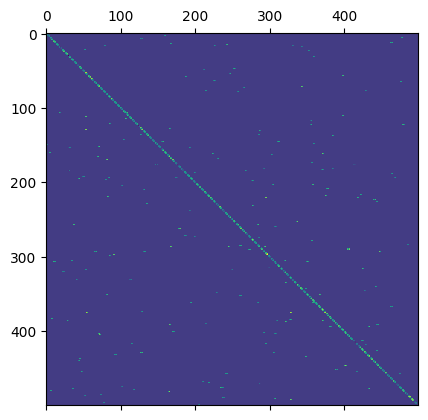

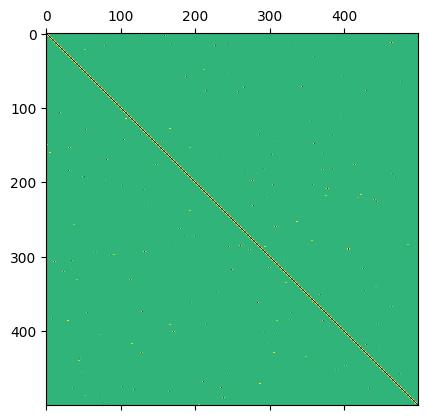

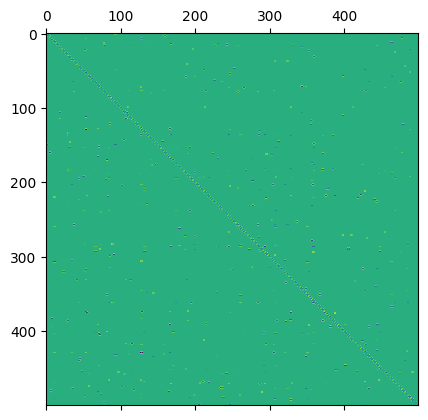

In [150]:
testing(gtransformer, dataloader)

## (Misc) Models

Models I just had an idea with. Not sure if I will use this section, but its here.